# Deep Probabilistice Generative Models - Variational Auto-Encoders


In [1]:
import torch
import torch.nn as nn
import torch.optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.distributions.bernoulli import Bernoulli

torch.manual_seed(0)

from models import *

import os
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib
import math

%matplotlib inline

In [2]:
train_dataset = datasets.MNIST(root='./mnist_data/', 
                               train=True,
                               transform=transforms.Compose([transforms.ToTensor(), 
                                                             lambda x : x>=0.5,
                                                             lambda x : x.reshape(-1).float()]),
                               download=True)

In [3]:
dim_input = 28*28
n_epoch = 30
batch_dim = 256
latent_dim = 128 
hidden_dim = 400
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, 
                                           batch_size = batch_dim, 
                                           shuffle = True)

In [4]:
encoder = GaussianEncoder(dim_input, hidden_dim, latent_dim)
decoder = GaussianPriorDecoder(latent_dim, hidden_dim, dim_input)

kl_div_1 = []
recons_1 = []
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))

for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0

    decoder.train()
    encoder.train()
    for i, (batch, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        mu, log_sigma_squared = encoder(batch)
        sigma = torch.exp(0.5*log_sigma_squared)

        e = torch.empty_like(mu).normal_(mean=0.,std=1.)
        z = mu + e*sigma

        reconstruction_logits = decoder(z)
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        )
        
        kl_div = KL_with_gaussian_prior(mu, log_sigma_squared)
        elbo = -reconstruction_loss.sum(1) - kl_div 
        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div.sum().item()
        
        loss = -elbo.mean()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        
        optimizer.step()
        
    print(
        epoch, ":\t",
        epoch_reconstruction/len(train_loader.dataset),
        "\t",
        epoch_kl/len(train_loader.dataset)
    )
    # We save values of kl divergence and recons loss to plot them later.
    kl_div_1.append(kl_div.sum().item())
    recons_1.append(-reconstruction_loss.sum().item())

0 :	 -173.6395814778646 	 13.644119317626954
1 :	 -114.11152384440105 	 22.155672615559897
2 :	 -95.55970328776041 	 25.84108904622396
3 :	 -82.92540799153646 	 27.182448657226562
4 :	 -74.33489382324218 	 27.936388598632814
5 :	 -68.50487374674479 	 28.79264375406901
6 :	 -64.66825358886719 	 29.536630261230467
7 :	 -61.99983944498698 	 30.13790946451823
8 :	 -60.193170385742185 	 30.501958374023438
9 :	 -58.80819848632812 	 30.80348983968099
10 :	 -57.758608748372396 	 31.039420878092447
11 :	 -56.88251370442708 	 31.248616910807293
12 :	 -56.132901147460935 	 31.383963028971355
13 :	 -55.46657678222656 	 31.56654610595703
14 :	 -54.87982587890625 	 31.684205126953124
15 :	 -54.284341552734375 	 31.85307430013021
16 :	 -53.84355160319011 	 31.982402718098957
17 :	 -53.351163802083335 	 32.09334825846354
18 :	 -52.98789439290365 	 32.21215075683594
19 :	 -52.629912947591144 	 32.28016799723307
20 :	 -52.28698518066406 	 32.34178866373698
21 :	 -51.98965953776042 	 32.45831990966797
22

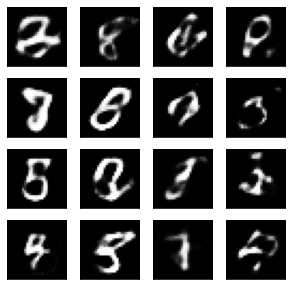

In [5]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_distributions(4*4)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

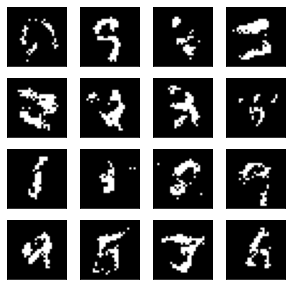

In [6]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=False)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

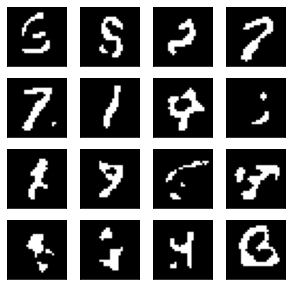

In [7]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=True)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

## 3. VAE with binary latent space and binary observed space



In [8]:
encoder = BernoulliEncoder(dim_input, hidden_dim, latent_dim)
decoder = BernoulliPriorDecoder(latent_dim, hidden_dim, dim_input)
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()))
kl_div_2 = []
recons_2 = []

running_avg = 0  # to control the variance of the SFE
n_updates = 0
for epoch in range(n_epoch):
    epoch_reconstruction = 0
    epoch_kl = 0
    
    decoder.train()
    encoder.train()
    for i, (batch, _) in enumerate(train_loader): 
        optimizer.zero_grad()

        probs = encoder(batch)

        m = Bernoulli(probs = probs)
        z = m.sample()
        log_probs = m.log_prob(z)
        # we sum over the second dimensions using the independency of (z_i).
        log_probs_sum = log_probs.sum(-1) 
        # Now log_probs_sum has shape (batch_dim,) 

        # We pass the sampled z from the encoder output through the decoder.
        # the decoder will return reconstructed image without applying sigmoid.
        reconstruction_logits = decoder(z)  

        # We compute the BCE loss and summing over the second dimension 
        # Mathematically the BCE is - reconstruction_loss actualy.
        # but we named the variable reconstruction loss anyway.
        reconstruction_loss = F.binary_cross_entropy_with_logits(
            reconstruction_logits,
            batch,
            reduction="none"
        ).sum(-1)

        kl_div_bern = KL_with_bernoulli_prior(probs)
        # We detach the reconstruction loss in the score function estimator
        # runing average is the mean of all previous reconstruction losses
        SFE  = - log_probs_sum * (reconstruction_loss.detach() - running_avg)
        
        # The two first terms are actually what we want to minimize
        # we added another term SFE to have correct gradients during training
        # and we added another SFE.detach() to recover the values of the loss we really
        # want to minimize
        loss = reconstruction_loss + kl_div_bern - SFE + SFE.detach()
        loss = loss.mean()

        epoch_reconstruction += -reconstruction_loss.sum().item()
        epoch_kl += kl_div_bern.sum().item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), 5)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), 5)
        optimizer.step()
        n_updates += 1
        # update the running_avg
        running_avg += (reconstruction_loss.detach().mean() - running_avg) / n_updates
       
    print(
        epoch, ":\t",
        epoch_reconstruction/len(train_loader.dataset),
        "\t",
        epoch_kl/len(train_loader.dataset),
    )
    # We save values of kl divergence and recons loss to plot them later.
    kl_div_2.append(kl_div_bern.sum().item())
    recons_2.append(-reconstruction_loss.sum().item())

0 :	 -209.54417799479165 	 3.479160494359334
1 :	 -166.86301127929687 	 9.720332674153646
2 :	 -148.03793608398436 	 13.822507745361328
3 :	 -139.93900231119792 	 15.859990445963541
4 :	 -135.06690249023438 	 17.13972275797526
5 :	 -131.1378012044271 	 18.109950256347656
6 :	 -127.56680919596354 	 19.19092214558919
7 :	 -125.08011041666667 	 19.696863098144533
8 :	 -122.35494503580729 	 20.828261043294273
9 :	 -119.9769290201823 	 21.403509818522135
10 :	 -117.72809677734375 	 22.255160180664063
11 :	 -116.72324498697917 	 21.88277770589193
12 :	 -114.28834295247395 	 22.94984938151042
13 :	 -112.22187766927084 	 24.07291298421224
14 :	 -111.0762705891927 	 23.828159712727864
15 :	 -108.90636282552083 	 24.894814453125
16 :	 -107.33590854492188 	 25.161081986490885
17 :	 -105.92193868815104 	 25.701359696451824
18 :	 -104.02275543619791 	 26.71450956217448
19 :	 -103.11489098307291 	 26.36672255045573
20 :	 -102.64636985677083 	 26.665167647298176
21 :	 -101.04903551432292 	 27.6226621

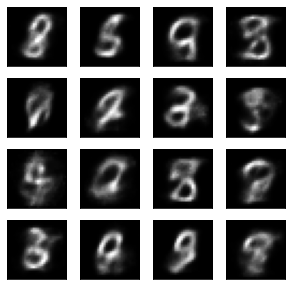

In [9]:
decoder.eval()
fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_distributions(4*4)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.view(-1,28,28).detach().numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

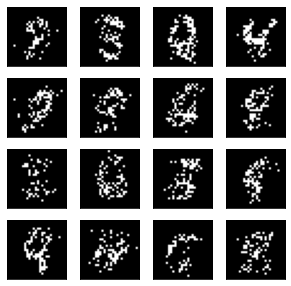

In [10]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=False)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

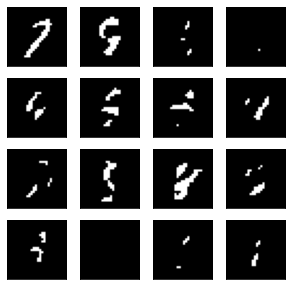

In [11]:
decoder.eval()

fig , axs = plt.subplots(4,4, figsize = (5,5))
with torch.no_grad():
    samples = decoder.sample_images(4*4, argmax=True)
    for i in range(4):
        for j in range(4):
            axs[i,j].imshow(samples.detach().view(-1,28,28).numpy()[i*4+j], cmap='gray')
            axs[i,j].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
    plt.show()

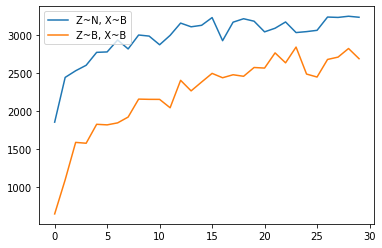

In [12]:
plt.plot(kl_div_1, label = 'Z~N, X~B')
plt.plot(kl_div_2, label = 'Z~B, X~B')
plt.legend(loc="upper left")
plt.show()

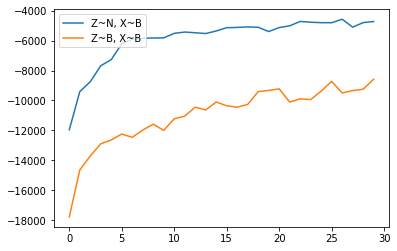

In [13]:
plt.plot(recons_1, label = 'Z~N, X~B')
plt.plot(recons_2, label = 'Z~B, X~B')
plt.legend(loc="upper left")
plt.show()